# MuML Labor 1 - SNR und Kontrast

Dieses Jupyter-notebook ist nur als Startpunkt für die Entwicklung der Lösungen gedacht.


**Idee**

Ermittlung eines homogenen hellen und homogenen dunklen Bereichs und
Bestimmung von SNR und von Kontrast - einmal über for Schleifen und einmal
über Nutzung von Bibliotheken

## Import der benötigten Bibliotheken

Alle Bibliotheken sind auf den Laborrechnern in der Anaconda-Umgebung ```muml``` bereits installiert. Um auf diese zugreifen zu können, sind die folgenden Schritte erforderlich:

1. Windows-Anwendung ```Anaconda Prompt``` öffnen
2. Umgebung  ```muml``` per Befehlseingabe ```conda activate muml``` aktivieren
3. per ```cd``` (change directory) in das gewünschte Verzeichnis wechseln
4. Entwicklungsumgebung starten, VS Code mittels ```code .``` (Punkt für aktuelles Verzeichnis)

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time
import timeit

file = "..\\labdata\\lab1u2_images\\001_disconnectedarea_crack_shunt.jpg"


## 3.4.2 Region of Interest

Die Region of Interest (ROI) ist ein Bildbereich, der für die weitere Verarbeitung von
Interesse ist. Für die Solarzellenprüfung soll der dunkle Randbereich des Bildes um die
Solarzelle nicht betrachtet werden. Dazu ist die Funktion get_roi(image) zu entwickeln,
die als Parameter ein Grauwertbild, die Koordinaten der oberen linken Ecke und
die Breite und Höhe des gewünschten Bildbereiches der Solarzelle ohne Rand erhält und
diesen zurückgibt. Zur Vereinfachung der weiteren Schritte ist der Rand so großzügig zu
wählen, dass die dunklen diagonalen Eckbereiche nicht Gegenstand des Bildes sind. Diese
Funktion darf die Bibliothekt numpy und den Colon-Operator (Slicing) verwenden, und
ist wie folgt aufzurufen:

```roi = get_roi(image, row1, col1, width, height)```

Es sind geeignete Koordinaten zu identifizieren, die den Rand für das Bild einschließlich
der diagonalen Eckbereiche im ```Bild 001_....jpg``` vollständig ausblenden, aber einen
möglichst minimalen Teil der Solarzelle. Die Funktion ist auf das Bild 001_....jpg
anzuwenden und das Ergebnisbild ist auszugeben.

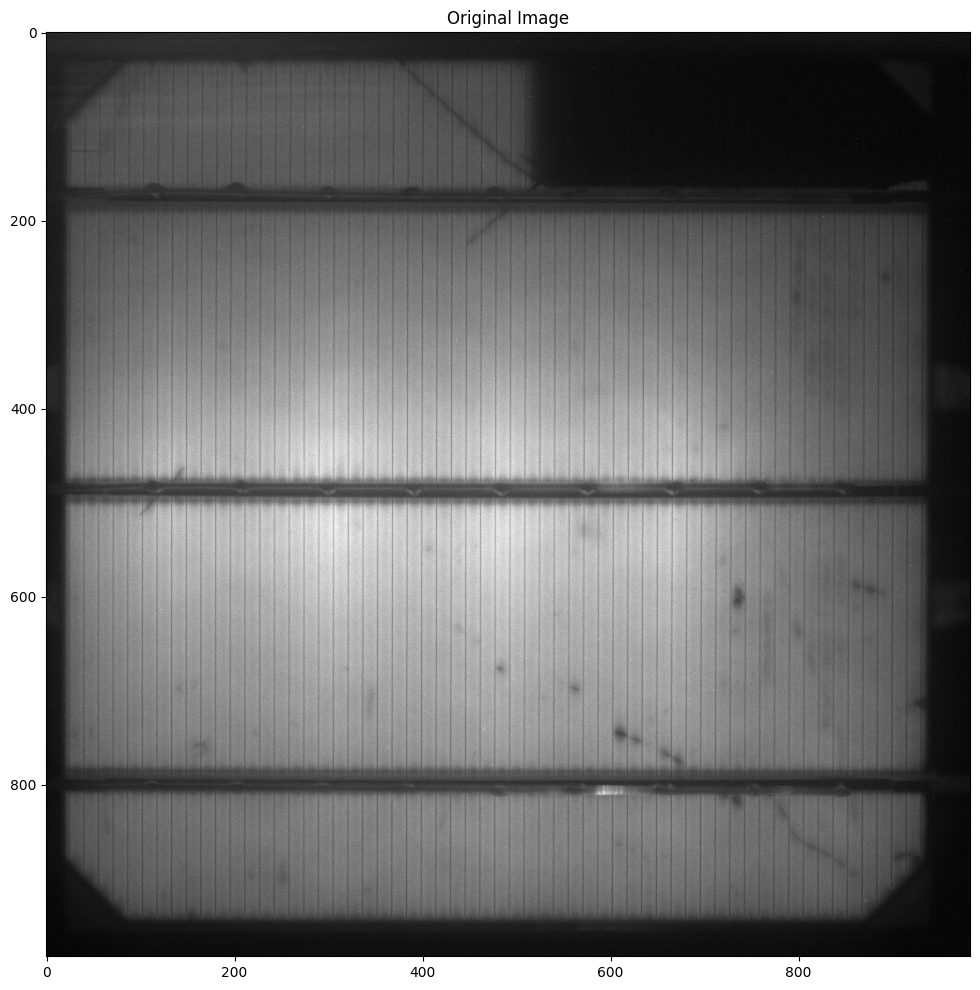

In [2]:
img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 12))
plt.imshow(img, cmap='gray') # colormap gray, to avoid false color scheme
plt.title('Original Image')
plt.show()

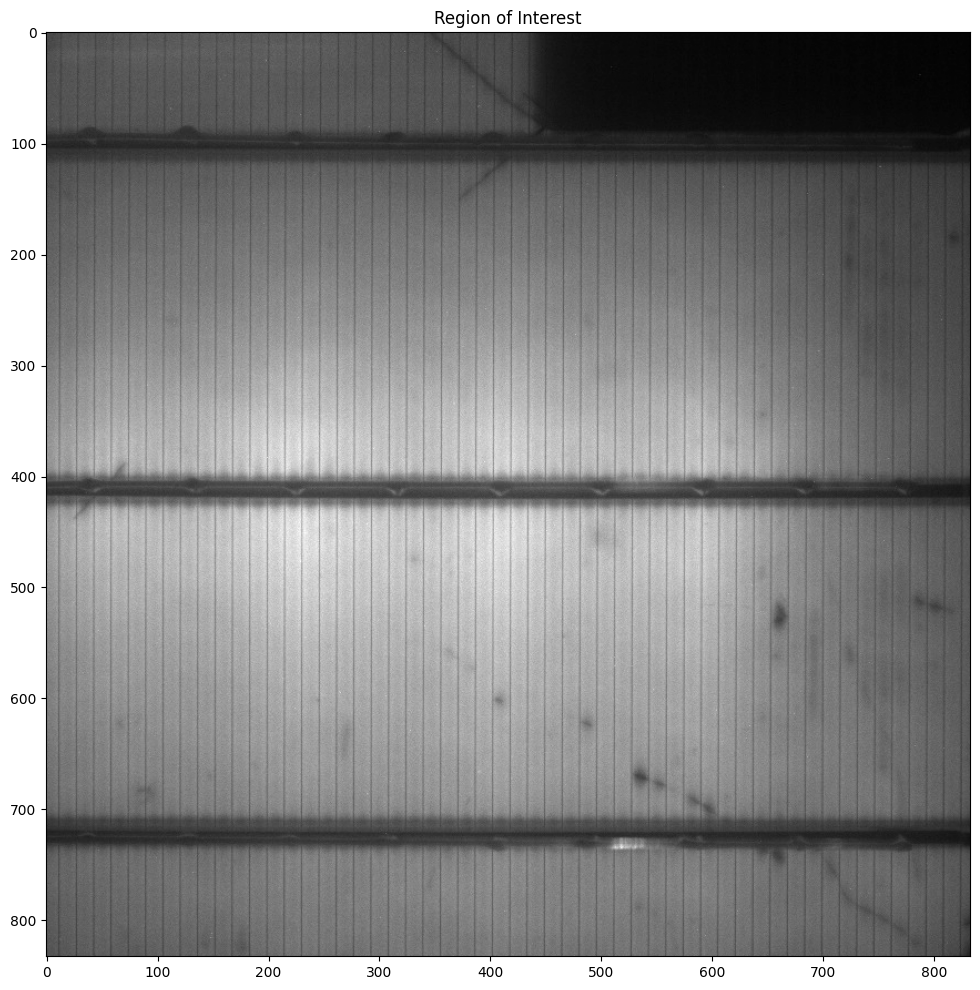

In [5]:
def get_roi(img, row1, col1, row2, col2):
    return img[row1:row2, col1:col2]

SCHNITT = 75
img_width, img_height = img.shape

row1 = SCHNITT
col1 = SCHNITT
row2 = img_width - SCHNITT
col2 = img_height - SCHNITT

roi = get_roi(img, row1, col1, row2, col2)
plt.figure(figsize=(12, 12))
plt.imshow(roi, cmap='gray')
plt.title('Region of Interest')
plt.show()

## 3.4.3 Bereinigung um Busbars

Zur Vereinfachung der späteren Auswertung, sollen die Bereiche der Busbars aus der ROI
eliminiert werden. Aufgrund der Konstruktion des Zelltesters sind die Busbars stets horizontal
angeordnet und haben eine definierte Höhe. Die Anzahl und Position der Busbars
kann je Solarzellentyp variieren, ist aber bei dieser Prüfung als bekannt vorauszusetzen.
Die Höhe und Positionen der Busbars soll daher parametrierbar sein, aber händisch eingestellt
werden. Es ist eine Funktion discard_busbars zu entwickeln, die die eingelesene
ROI um die zu eliminierenden Busbars verkleinert und diese als ein zusammenhängendes
Bild ausgibt. Die Funktion erhält als Parameter die ROI, die Höhe der Busbars und eine
Liste der oberen Zeile des jeweiligen Busbars und ist wie folgt aufzurufen:

```roi = discard_busbars(roi, bar_height, [<list of rows>])```

Die Funktion ist auf das ```Bild 001_....jpg``` anzuwenden und das Ergebnisbild auszugeben.

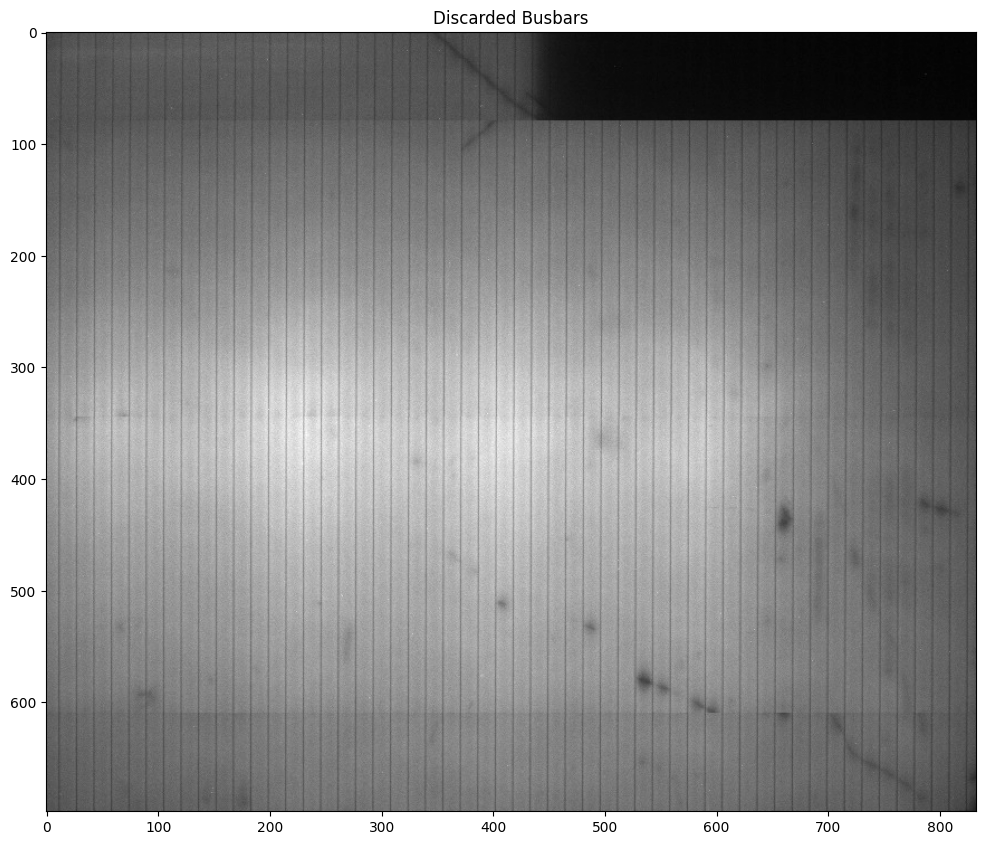

In [6]:
def discard_busbars(img, bar_height, positions):

    img_discarded_bars = np.empty((0, img.shape[1]), dtype=img.dtype) # leere Bildzeile erzeugen
    top_row = 0
    for pos in positions:
        cropped_img = img[top_row:pos, :]
        top_row = pos + bar_height # Busbar überspringen
        img_discarded_bars = np.append(img_discarded_bars, cropped_img, axis=0)

    last_part = img[top_row:, :]
    img_discarded_bars = np.append(img_discarded_bars, last_part, axis=0)

    return img_discarded_bars

roi_discarded_bars = discard_busbars(roi, 45, [80, 390, 700])
plt.figure(figsize=(12, 12))

# Visualisierung der Bildausschnitte für die SNR und Kontrastbestimmung. Die Rechtecke dürfen nicht mit in die Berechnung einfließen!
# cv2.rectangle(roi_discarded_bars, (30, 400), (40, 590), (0, 255, 0), 1)
# cv2.rectangle(roi_discarded_bars, (545, 25), (800, 67), (0, 255, 0), 1)


plt.imshow(roi_discarded_bars, cmap='gray')
plt.title('Discarded Busbars')
plt.show()

## 3.4.4 SNR und Kontrast

Es ist je eine Funktion mit und ohne Nutzung der Bibliotheken numpy bzw. openCV zu
entwickeln, die den Mittelwert und die Standardabweichung der Grauwerte eines Bildbereiches
berechnet. Diese soll einmal auf einen hellen, möglichst homogenen Bildbereich
zwischen den Fingern sowie einmal auf einen dunklen homogenen Bereich aus dem Bild
001_....jpg angewandt werden. Dazu ist die um Busbar bereinigte ROI zu analysieren
und und ein geeigneter Bildbereich zu identifizieren. Nach Aufruf der entwickelten
Funktion sind aus den Rückgabewerten der Kontrast als Differenz der Mittelwerte zwischen
dem hellen und dunklen Bereich und das SNR der beiden Bereiche zu bestimmen
und auszugeben.


Das Signal-Rausch-Verhältnis definiert sich über den Mittelwert der Grauwerte $\mu_y$ des
betrachteten Bereiches und dessen Standardabweichung $\sigma_y$ als:

$$SNR = \frac{\mu_y}{\sigma_y}$$

Das SNR ist in dB umzurechnen:
$$SNR_{dB} = 20 \cdot log_{10}(SNR)$$

Das SNR ist bezüglich der Signalqualität zu bewerten und der Unterschied der Signal-
Rausch-Verhältnisse in einem Markdown-Feld des Jupyter notebooks zu erklären.
Um die Laufzeitunterschiede zwischen der händischen Implementierung und mit der Bibliothek
vergleichen zu können, sollen zwei Funktionen erstellt werden, die die Ergebnisse
zurückliefern, aber in der Funktion selbst nicht ausgeben:


```mean, snr = calc_mean_snr_with_loop(image, row1, col1, row2, col2)```

```mean, snr = calc_mean_snr_with_bib(image, row1, col1, row2, col2)```

### Implementierung mit For-Loop

In [7]:
import math

def calc_mean_snr_with_loop(image, row1, col1, row2, col2):
    """ calculate the mean and the standard deviattion of the rectangle area in the image
        using only loops and no numpy functions (image is a numpy array, that's allowed)"""

    # Durchschnitt:
    sum = 0.0
    count = 0
    for y in range(row1, row2):
        for x in range(col1, col2):
            sum += float(image[y,x])
            count += 1

    mean = sum / count

    # Standardabweichung:
    sum_quadrat = 0.0
    for y in range(row1, row2):
        for x in range(col1, col2):
            sum_quadrat += (float(image[y,x])- mean) ** 2

    std = math.sqrt(sum_quadrat/(count-1))

    return mean, std

bright_area = [400, 30, 590, 40]  #row1, col1, row2, col2
dark_area = [25, 545, 67, 800] #row1, col1, row2, col2

start = time.time()
mean_bright, std_bright = calc_mean_snr_with_loop(roi_discarded_bars, *bright_area)
mean_dark, std_dark = calc_mean_snr_with_loop(roi_discarded_bars, *dark_area)
stop = time.time()

print(f"bright area: mean {mean_bright:.1f}, std: {std_bright:.1f}, SNR: {(math.log10(mean_bright/std_bright) * 20):.1f} dB")
print(f"dark area: mean {mean_dark:.1f}, std: {std_dark:.1f}, SNR: {(math.log10(mean_dark/std_dark) * 20):.1f} dB")
print(f"Contrast between mean of bright and dark area: {mean_bright - mean_dark:.1f}")
print(f"Time taken: {stop - start:.3f} seconds")

execution_timeit = timeit.timeit('calc_mean_snr_with_loop(roi_discarded_bars, *bright_area)', globals=globals(), number=1000)
execution_timeit += timeit.timeit('calc_mean_snr_with_loop(roi_discarded_bars, *dark_area)', globals=globals(), number=1000)
print(f"Time taken with timeit: {execution_timeit / 1000:.3f} seconds")
print(f"Time taken with timeit 1000x: {execution_timeit:.3f} seconds")

bright area: mean 104.2, std: 10.6, SNR: 19.8 dB
dark area: mean 9.8, std: 1.3, SNR: 17.4 dB
Contrast between mean of bright and dark area: 94.5
Time taken: 0.006 seconds
Time taken with timeit: 0.005 seconds
Time taken with timeit 1000x: 4.835 seconds


###  Implementierung mit numpy

In [8]:
def calc_mean_snr_with_numpy(image, row1, col1, row2, col2):
    """ calculate the mean and the standard deviattion of the rectangle area in the image
        using numpy functions"""

    region = image[row1:row2, col1:col2]
    mean = np.mean(region)

    std = np.std(region, ddof=1)
    return mean, std

In [9]:
start = time.time()
mean_bright, std_bright = calc_mean_snr_with_numpy(roi_discarded_bars, *bright_area)
mean_dark, std_dark = calc_mean_snr_with_numpy(roi_discarded_bars, *dark_area)
stop = time.time()


print(f"bright area: mean {mean_bright:.1f}, std: {std_bright:.1f}, SNR: {(math.log10(mean_bright/std_bright) * 20):.1f} dB")
print(f"dark area: mean {mean_dark:.1f}, std: {std_dark:.1f}, SNR: {(math.log10(mean_dark/std_dark) * 20):.1f} dB")
print(f"Contrast between mean of bright and dark area: {mean_bright - mean_dark:.1f}")
print(f"Time taken: {stop - start:.3f} seconds")

# Vergleich der Ausführungszeit mit timit gemessen
import timeit
exec_time = timeit.timeit('calc_mean_snr_with_numpy(roi_discarded_bars, *bright_area)', globals=globals(), number=100000)
print("100000fache Ausführung:", exec_time, "seconds")
print(f"Einfache Ausführung: {exec_time / 100:.3f} ms")

bright area: mean 104.2, std: 10.6, SNR: 19.8 dB
dark area: mean 9.8, std: 1.3, SNR: 17.4 dB
Contrast between mean of bright and dark area: 94.5
Time taken: 0.000 seconds
100000fache Ausführung: 2.9521383999381214 seconds
Einfache Ausführung: 0.030 ms


### Implementierung mit OpenCV

In [ ]:
def calc_mean_snr_with_cv2(image, row1, col1, row2, col2):
    """ calculate the mean and the standard deviation of the rectangle area in the image
        using cv2 functions"""
    
    mask = np.zeros(image.shape, dtype=np.uint8)
    mask[row1:row2, col1:col2] = 255
    mean, std = cv2.meanStdDev(image, mask=mask)

    return mean[0][0], std[0][0]

In [23]:
start = time.time()
mean_bright, std_bright = calc_mean_snr_with_cv2(roi_discarded_bars, *bright_area)
mean_dark, std_dark = calc_mean_snr_with_cv2(roi_discarded_bars, *dark_area)
stop = time.time()


print(f"bright area: mean {mean_bright:.1f}, std: {std_bright:.1f}, SNR: {(math.log10(mean_bright/std_bright) * 20):.1f} dB")
print(f"dark area: mean {mean_dark:.1f}, std: {std_dark:.1f}, SNR: {(math.log10(mean_dark/std_dark) * 20):.1f} dB")
print(f"Contrast between mean of bright and dark area: {mean_bright - mean_dark:.1f}")
print(f"Time taken: {stop - start:.3f} seconds")

# Vergleich der Ausführungszeit mit timit gemessen
import timeit
exec_time = timeit.timeit('calc_mean_snr_with_cv2(roi_discarded_bars, *bright_area)', globals=globals(), number=10000)
print("10000fache Ausführung:", exec_time, "seconds")
print(f"Einfache Ausführung: {exec_time/10:.3f} ms")

bright area: mean 104.2, std: 10.6, SNR: 19.8 dB
dark area: mean 9.8, std: 1.3, SNR: 17.4 dB
Contrast between mean of bright and dark area: 94.5
Time taken: 0.001 seconds
10000fache Ausführung: 3.106231499928981 seconds
Einfache Ausführung: 0.311 ms


### Bewertung
Das Signal-Rausch-Verhältnis mit 19.8 dB ist schlecht (akzeptabel ab 20dB). Das liegt daran, dass benachbarte Pixel im hellen Bereich teilweise hohe Schwankungen in der Helligkeit aufweisen.

Der Kontrast von 94.5 reizt nicht das gesamte Helligkeitsspektrum (0-255) aus. Hier ist eine deutliche Verbesserung durch eine Grauwertspreizung zu erwarten.

Die Implementierung mit for-Schleifen ist über ein großes Bild sehr langsam, da Python eine interpretierte Sprache ist und kaum Verbesserungen vornehmen kann, während die Bibliotheken auf einer effizienteren, hardwarenäheren Implementierung beruht.

## 3.4.5 Kontrastverbesserung

Es ist der minimale und maximale Grauwert des Bildes zu ermitteln und eine Kontrastverbesserung
des Bildes unter Nutzung einer Grauwertspreizung auf den Wertebereich 0
. . . 255 als Funktion contrast_stretching(image) auszuführen.
Die korrekte Funktion ist durch Anzeige der um Busbar bereinigten ROI zu prüfen und
es sind erneut das SNR für den hellen und dunklen Bereich zu bestimmen. Das Ergebnis
ist in einem Markdown-Feld zu interpretieren.

**Tipp:** Falls hier kein Unterschied zu obigen Ausgaben visuell zu erkennen ist, wurde vielleicht zuvor das Bild mittels ```plt.imshow``` angezeigt, ohne die automatische Bildverbesserung per Parameter ```vmin=0, vmax=255``` zu deaktivieren, wie unten am Beispiel gezeigt.  

min Wert alt = 4, max Wert alt = 183
min Wert neu = 0, max Wert neu = 255


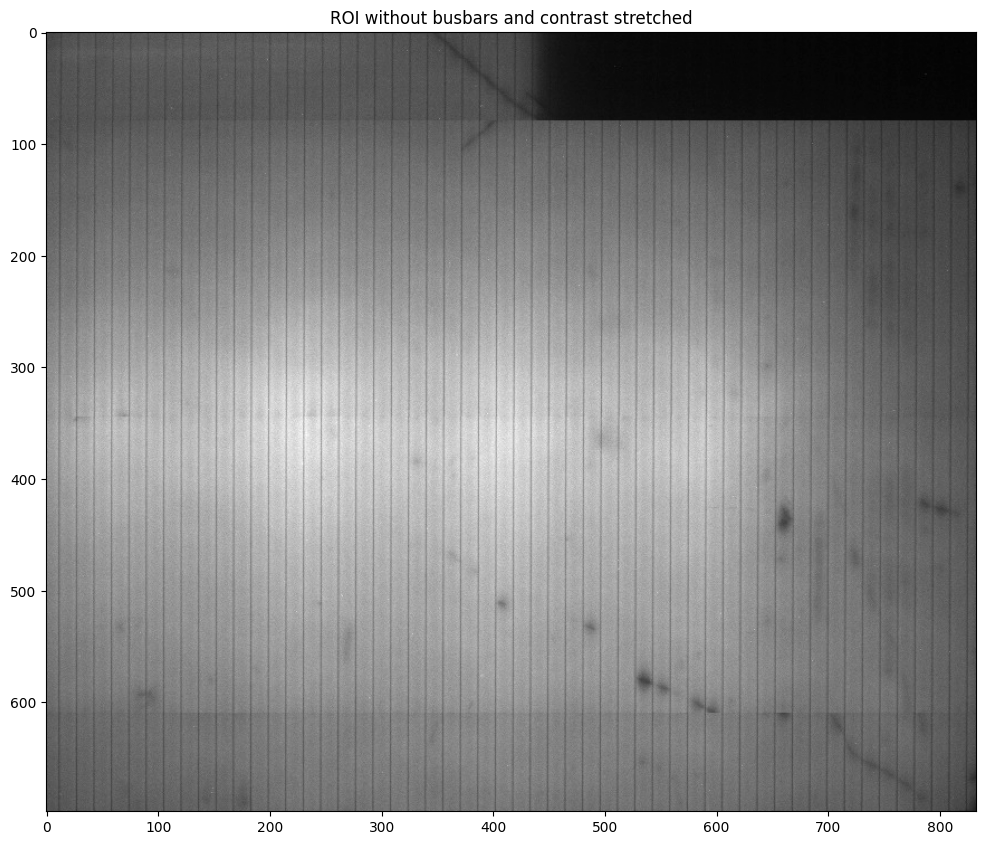

In [34]:
def contrast_stretching(img):
    """ apply contrast stretching to the image"""
    min_val, max_val, _, _ = cv2.minMaxLoc(img)
    print("min Wert alt = %d, max Wert alt = %d" % (min_val, max_val))
    stretched = ((img-min_val)/(max_val - min_val))*255

    min_val, max_val, _, _ = cv2.minMaxLoc(stretched)
    print("min Wert neu = %d, max Wert neu = %d" % (min_val, max_val))
    return stretched.astype(np.uint8)

roi_discarded_bars_stretched = contrast_stretching(roi_discarded_bars)
cv2.imwrite('roi_discarded_bars_stretched.jpg', roi_discarded_bars_stretched)
plt.figure(figsize=(12, 12))
plt.imshow(roi_discarded_bars_stretched, cmap='gray', vmin=0, vmax=255)
plt.title('ROI without busbars and contrast stretched')
plt.show()

In [26]:
def evaluate(img):
    mean_bright, std_bright = calc_mean_snr_with_numpy(img, *bright_area)
    mean_dark, std_dark = calc_mean_snr_with_numpy(img, *dark_area)

    print(f"bright area: mean {mean_bright:.1f}, std: {std_bright:.1f}, SNR: {(math.log10(mean_bright/std_bright) * 20):.1f} dB")
    print(f"dark area: mean {mean_dark:.1f}, std: {std_dark:.1f}, SNR: {(math.log10(mean_dark/std_dark) * 20):.1f} dB")
    print(f"Contrast between mean of bright and dark area: {mean_bright - mean_dark:.1f}")

evaluate(roi_discarded_bars_stretched)

bright area: mean 142.3, std: 15.1, SNR: 19.5 dB
dark area: mean 7.7, std: 1.8, SNR: 12.7 dB
Contrast between mean of bright and dark area: 134.6


### Bewertung
Durch die Grauwertspreizung hat sich der Durchschnitt des hellen und dunklen Bereichs leicht geändert. Insbesondere der helle Bereich ist deutlich heller geworden, da das vorherige Helligkeitsmaximum bei 183 lag und auf 255 erhöht wird, wodurch gerade die hellen Bereiche im Histogram ins hellere verschoben wurden. Zusätzlich hat sich auch die Standardabweichung erhöht. Das liegt daran, dass die Grauwertspreizung auch das Rauschen spreizt und damit größere Unterschiede vorkommen. Da aber beide Werte gleichermaßen erhöht wurden, bleibt das Verhältnis, also das SNR, nahezu gleich.

Der dunkle Bereich hat nach der Spreizung deutlich mehr Rauschen. Hier sind hohe Schwankungen aber auch zu erwarten, da kleine Änderungen der niedrigen Grauwerte bereits große Auswirkungen auf das SNR haben.

## 3.4.6 Rauschreduktion

Es soll das Rauschen durch ein 5x5-Gauß-Filter mit einer Standardabweichung von
$\sigma = 1$ reduziert werden.

Das Filter wird als separierbar (separable Filter) bezeichnet, da der zweidimensionale
Filterkern auch als Verkettung von zwei eindimensionalen Filterkernen realisiert
werden kann. Dabei macht man sich zunutze, dass die sequentielle Faltung zweier
eindimensionaler Filterkerne mit weniger Rechenoperationen berechnet werden kann
als mit einem zweidimensionalen Kernel:

$$\begin{align}
    \begin{pmatrix}
        1 & 2 & 1 \\
        2 & 4 & 2 \\
        1 & 2 & 1
    \end{pmatrix}
    =
    \begin{pmatrix}
        1 \\
        2 \\
        1
    \end{pmatrix}
    \cdot
    \begin{pmatrix}
        1 & 2 & 1
    \end{pmatrix}
\end{align}
$$
Es sind die folgenden Funktionen zu entwickeln, wobei die Filterung
nur auf dem inneren Bildbereich durchgeführt wird, um Randeffekte zu vermeiden:

Es sind die folgenden Funktionen zu entwickeln, wobei die Filterung nur auf dem inneren
Bildbereich durchgeführt wird, um Randeffekte zu vermeiden:
- ```get_gauss_kernel(size, sigma)```: Berechnet den Filterkern für eine gegebene ungeradzahlige Größe des Kernels size=(rows, cols) und Standardabweichung. Hierbei ist die Summe des Filterkerns auf den Wert 1 zu normieren. Die Nutzung von numpy ist zulässig, insbesondere auch die Funktion np.mgrid.
- ```filter_1d_horizontal(image, kernel)```: Filtert das Bild mit einem horizontalen 1D-Filterkern. Die Implementierung soll durch for-Schleifen erfolgen.
- ```filter_1d_vertical(image, kernel)```: Filtert das Bild mit einem vertikalen 1D-Filterkern. Die Implementierung soll durch for-Schleifen erfolgen.
- ```filter_2d(image, kernel)```: Filtert das Bild mit einem 2D-Filterkern. Die Implementierung soll durch for-Schleifen erfolgen.
- ```filter_2d_with_bib(image, kernel)```: Filtert das Bild mit einem 2D-Filterkern unter Nutzung von numpy oder OpenCV.

Die Funktionen sind auf das ```Bild 001_....jpg``` unter Nutzung eines 5 x 5- Gauß-Filters
mit &\sigma = 1$ anzuwenden und das Ergebnisbild ist jeweils auszugeben. Die Laufzeitunterschiede
zwischen den Implementierungen als separierbare Faltung der sequentiell ausgeführten
1D-Filter und der Implementierung als 2D-Filter sowie der Implementierung
mittels OpenCV sind zu messen und zu vergleichen.

Es sind die Anzahl der notwendigen Multiplikationen für die Implementierung als separierbare
Faltung und als 2D-Filter zu berechnen und zu vergleichen.
Abschließend ist das Signal-Rausch-Verhältnis und der Kontrast des mittels OpenCV gefilterten
Bildes wie bei der Kontrastverbesserung in 3.4.5 zu bestimmen und zu bewerten
und in einem Markdown-Feld zu erklären.


### get_gauss_kernel

Formel für zweidimensionale Gauß-Verteilung:


$h(x) = \frac{1}{2 \pi \sigma^2} \cdot \exp(-\frac{x^2 + y^2}{2\cdot \sigma ^2})$

Hinweise auf mögliche Hilfsfunktionen:
- np.mgrid
- np.fromfunction

[[0.05448868 0.24420134 0.40261995 0.24420134 0.05448868]]


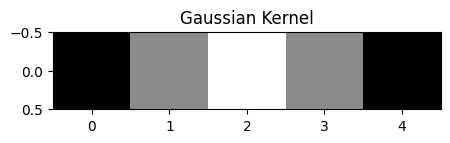

In [ ]:
def gauss(x,y,sigma): # Formel für zweidimensionale Gauß-Verteilung
    return 1/(2 * np.pi * sigma**2) * np.exp(-(x**2 + y**2) / 2 * sigma**2)

# Gauß-Kernel mittels numpy erzeugen
def get_gauss_kernel(size, sigma):
    height, width = size

    koordinaten = np.mgrid[-math.floor(height/2):math.ceil(height/2), -math.floor(width/2):math.ceil(width/2)] # Koordinaten mit 0 als Mittelpunkt der Matrix erzeugen
    x = koordinaten[0,:,:].astype(int) # height x width große Matrix der x-Koordinaten
    y = koordinaten[1,:,:].astype(int) # height x width große Matrix der y-Koordinaten

    kernel = gauss(x,y,sigma)
    gesamt_summe = sum(sum(kernel))
    return kernel / gesamt_summe


size = (1, 5)
sigma = 1
kernel = get_gauss_kernel(size, sigma)
print(kernel)

plt.figure(figsize=(5, 5))
plt.imshow(kernel, cmap='gray')
plt.title('Gaussian Kernel')
plt.show()


In [ ]:
# Hinweis zu möglicher Lösung: mgrid erzeugt ein 2D-Array, das die Koordinaten der Pixel enthält.
np.mgrid[-2:3, -2:3] # erster Wert ist Startwert, zweiter Wert ist einen größer als der Endwert

(2, 5, 5)

### filter_1d_horizontal

Size of original image: (698, 833)
Size of filtered image: (698, 833)
Number of multiplications: 2889720 in 1.550 seconds


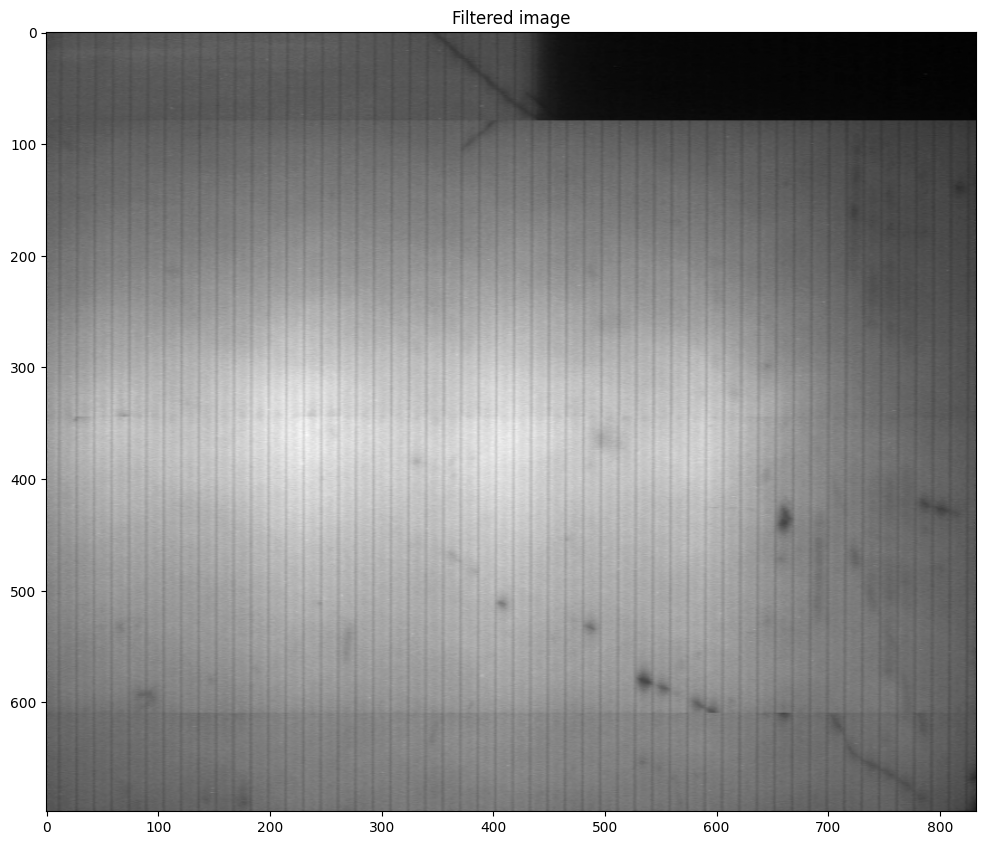

In [ ]:
def filter_1d_horizontal(img, kernel):
    """ apply a 1D filter to the image in horizontal direction"""
    kern = kernel[0,:]
    rand = math.floor(kern.size / 2)
    img_copy = img.copy() # Kopie des Bildes auf dem die gefilterten Werte gespeichert werden
    height, width = img.shape

    counter = 0

    for j_row in range(height):
        for i_col in range(width):
            if i_col > rand and i_col < width - rand: # Rand abschneiden, um Randeffekte zu vermeiden
                # Pixel + und - dem der halben Kernelgröße mit dem Kernel multiplizieren und aufsummieren
                img_copy[j_row,i_col] = sum(img[j_row, i_col-rand:i_col+rand+1] * kern)
                counter += kern.size # Jeder Wert im Kernel stellt eine Multiplikation dar

    return img_copy, counter

# apply the filter to the image
kernel = get_gauss_kernel((1, 5), 1)
start = time.time()
filtered_1d_horizontal, multiplications = filter_1d_horizontal(roi_discarded_bars_stretched, kernel)
stop = time.time()

print(f"Size of original image: {roi_discarded_bars_stretched.shape}")
print(f"Size of filtered image: {filtered_1d_horizontal.shape}")
print(f"Number of multiplications: {multiplications} in {stop - start:.3f} seconds")

plt.figure(figsize=(12, 12))
plt.imshow(filtered_1d_horizontal, cmap='gray')
plt.title('Filtered image')
plt.show()


### filter_1d_vertical

Size of original image: (698, 833)
Size of filtered image: (698, 833)
Number of multiplications: 2886345 in 1.559 seconds


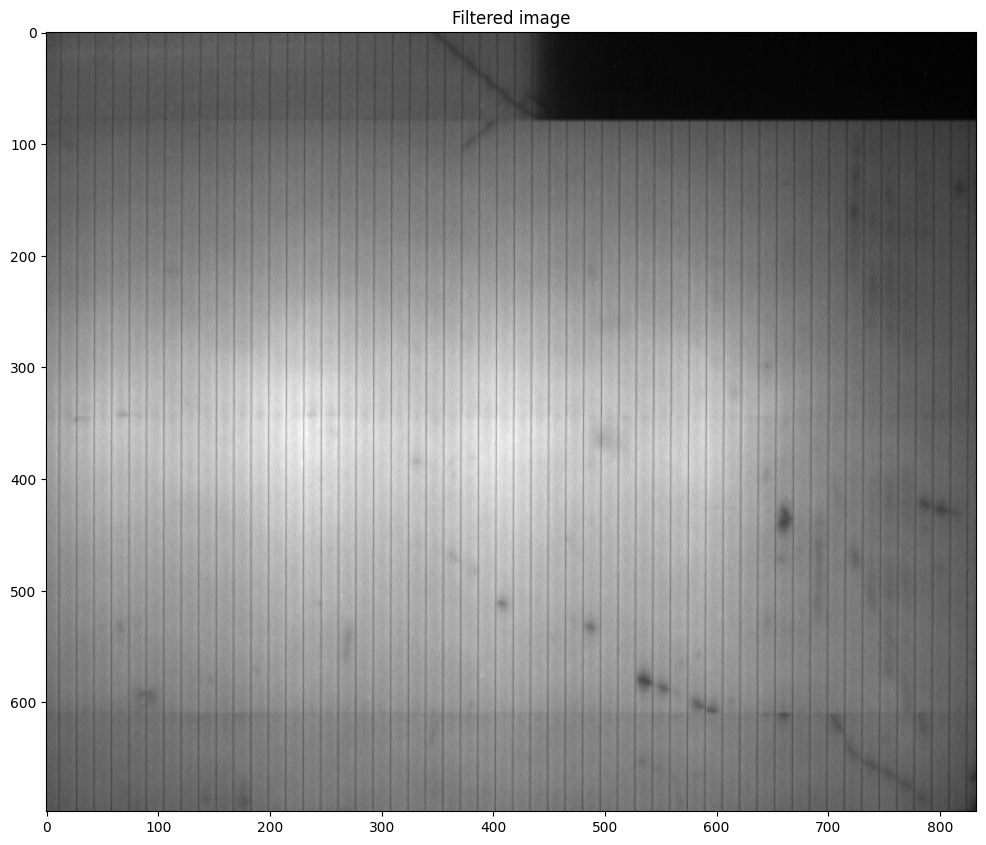

In [ ]:
def filter_1d_vertical(img, kernel):
    """ apply a 1D filter to the image in vertical direction"""
    kern = kernel[:,0]
    rand = math.floor(kern.size / 2)
    img_copy = img.copy() # Kopie des Bildes auf dem die gefilterten Werte gespeichert werden

    height, width = img.shape

    counter = 0

    for i_col in range(width):
        for j_row in range(height):
            if j_row > rand and j_row < height - rand: # Rand abschneiden, um Randeffekte zu vermeiden
                # Pixel + und - dem der halben Kernelgröße mit dem Kernel multiplizieren und aufsummieren
                img_copy[j_row,i_col] = sum(img[j_row-rand:j_row+rand+1, i_col] * kern)
                counter += kern.size # Jeder Wert im Kernel stellt eine Multiplikation dar

    return img_copy, counter

kernel = get_gauss_kernel((5, 1), 1)

start = time.time()
filtered_1d_vertical, multiplications = filter_1d_vertical(roi_discarded_bars_stretched, kernel)
stop = time.time()

print(f"Size of original image: {roi_discarded_bars_stretched.shape}")
print(f"Size of filtered image: {filtered_1d_vertical.shape}")
print(f"Number of multiplications: {multiplications} in {stop - start:.3f} seconds")

plt.figure(figsize=(12, 12))
plt.imshow(filtered_1d_vertical, cmap='gray')
plt.title('Filtered image')
plt.show()

### separable Gauss

Size of original image: (698, 833)
Size of filtered image: (698, 833)
Number of multiplications: 5776065 in 3.167 seconds
bright area: mean 141.3, std: 14.4, SNR: 19.9 dB
dark area: mean 6.8, std: 1.5, SNR: 13.2 dB
Contrast between mean of bright and dark area: 134.5


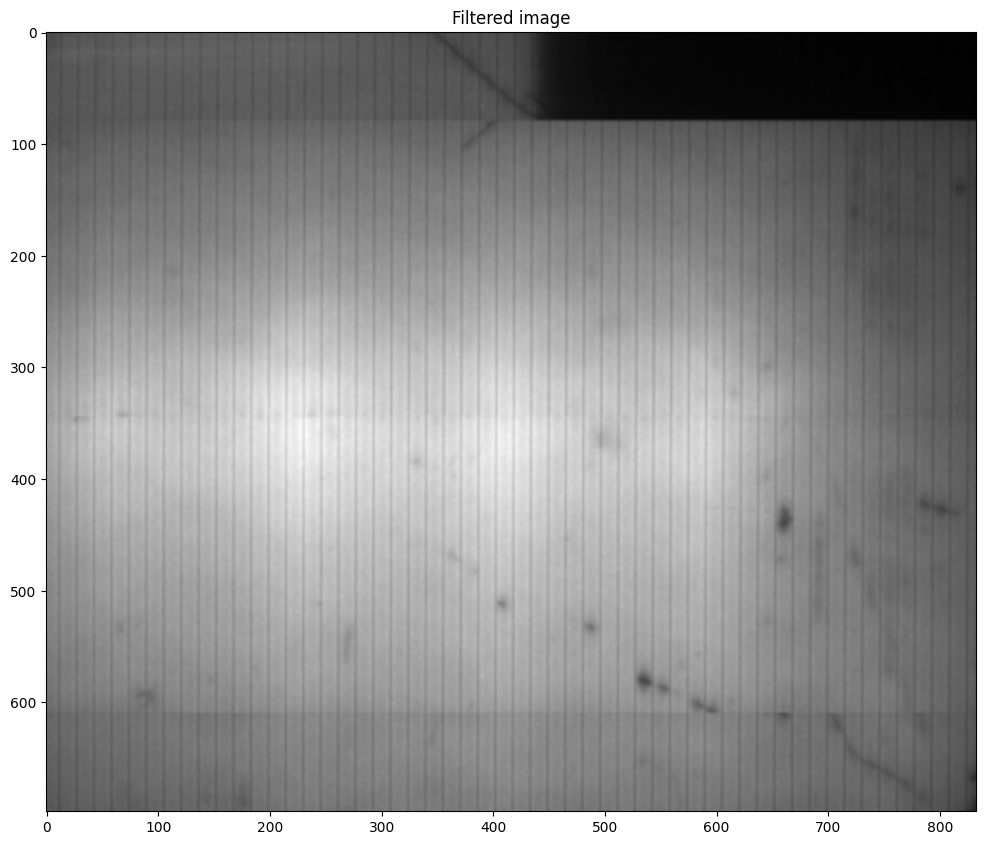

In [36]:
kernel_horizontal = get_gauss_kernel((1, 5), 1)
kernel_vertical = get_gauss_kernel((5, 1), 1)

start = time.time()

filtered_1d_both, mult1 = filter_1d_horizontal(roi_discarded_bars_stretched, kernel_horizontal)
filtered_1d_both, mult2 = filter_1d_vertical(filtered_1d_both, kernel_vertical)

stop = time.time()
elapsed_separable = stop - start

print(f"Size of original image: {roi_discarded_bars_stretched.shape}")
print(f"Size of filtered image: {filtered_1d_both.shape}")
print(f"Number of multiplications: {mult1 + mult2} in {elapsed_separable:.3f} seconds")
evaluate(filtered_1d_both)

plt.figure(figsize=(12, 12))
plt.imshow(filtered_1d_both, cmap='gray')
plt.title('Filtered image')
plt.show()

### filter_2d

Size of original image: (698, 833)
Size of filtered image: (698, 833)
Number of multiplications: 14345100 in 4.344 seconds
bright area: mean 141.8, std: 14.4, SNR: 19.9 dB
dark area: mean 7.2, std: 1.5, SNR: 13.6 dB
Contrast between mean of bright and dark area: 134.6


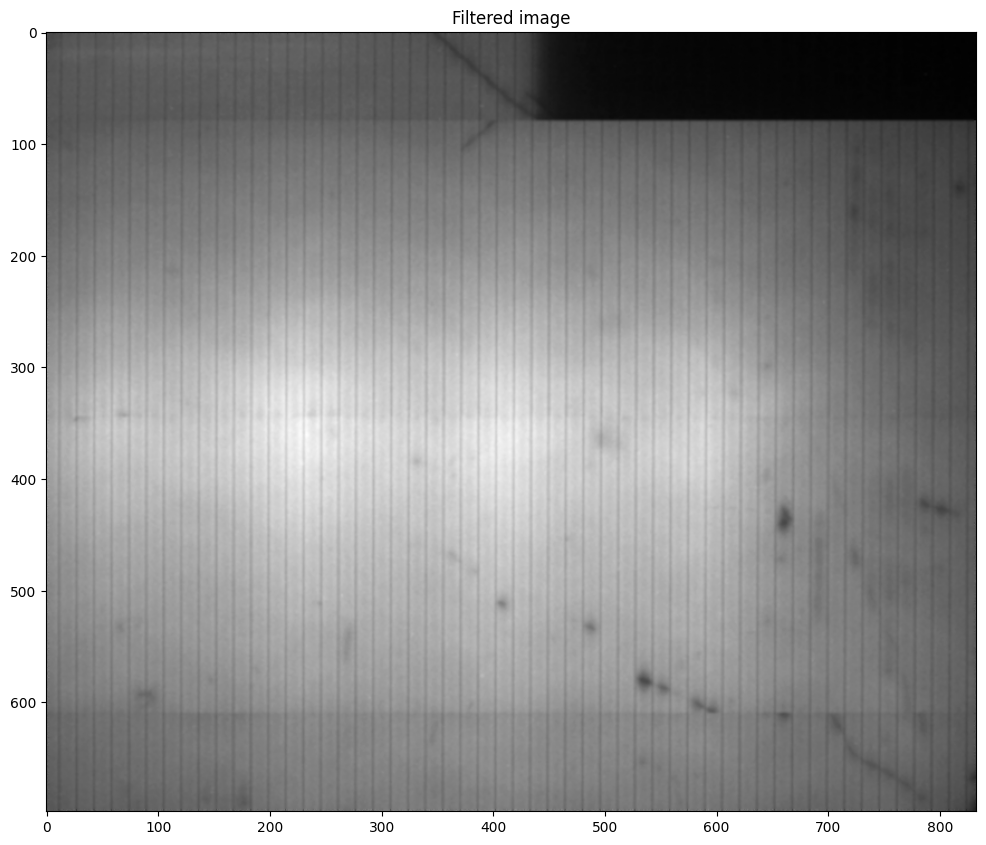

In [38]:
# filter the image with the 2D gaussian kernel with for loops

def filter_2d(img, kernel):
    """ apply a 2D filter to the image"""
    rand = math.floor(kernel[0,:].size / 2)
    img_copy = img.copy() # Kopie des Bildes auf dem die gefilterten Werte gespeichert werden

    height, width = img.shape

    counter = 0

    for i_col in range(width):
        for j_row in range(height):
            if j_row > rand and j_row < height - rand and i_col > rand and i_col < width - rand: # Rand abschneiden, um Randeffekte zu vermeiden
                # Pixel + und - dem der halben Kernelgröße mit dem Kernel multiplizieren und aufsummieren
                img_copy[j_row,i_col] = sum(sum(img[j_row-rand:j_row+rand+1, i_col-rand:i_col+rand+1] * kernel))
                counter += kernel.size # Jeder Wert im Kernel stellt eine Multiplikation dar

    return img_copy, counter


# apply the filter to the image
kernel = get_gauss_kernel((5, 5), 1)

start = time.time()
filtered_2d, mult3 = filter_2d(roi_discarded_bars_stretched, kernel)
stop = time.time()
elapsed_2d = stop - start

print(f"Size of original image: {roi_discarded_bars_stretched.shape}")
print(f"Size of filtered image: {filtered_2d.shape}")
print(f"Number of multiplications: {mult3} in {elapsed_2d:.3f} seconds")

evaluate(filtered_2d)

plt.figure(figsize=(12, 12))
plt.imshow(filtered_2d, cmap='gray')
plt.title('Filtered image')
plt.show()


In [39]:
print(f"2d Filter benötigt das {mult3 / (mult1 + mult2):.2f}-fache an Multiplikationen im Vergleich zu zwei 1D-Filtern")
print(f"2d Filter benötigt das {elapsed_2d / elapsed_separable:.2f}-fache an Zeit im Vergleich zu zwei 1D-Filtern")

2d Filter benötigt das 2.48-fache an Multiplikationen im Vergleich zu zwei 1D-Filtern
2d Filter benötigt das 1.37-fache an Zeit im Vergleich zu zwei 1D-Filtern


### opencv

Size of original image: (698, 833)
Size of filtered image: (698, 833)
Time taken: 0.003 seconds
bright area: mean 142.3, std: 14.4, SNR: 19.9 dB
dark area: mean 7.7, std: 1.5, SNR: 14.1 dB
Contrast between mean of bright and dark area: 134.6


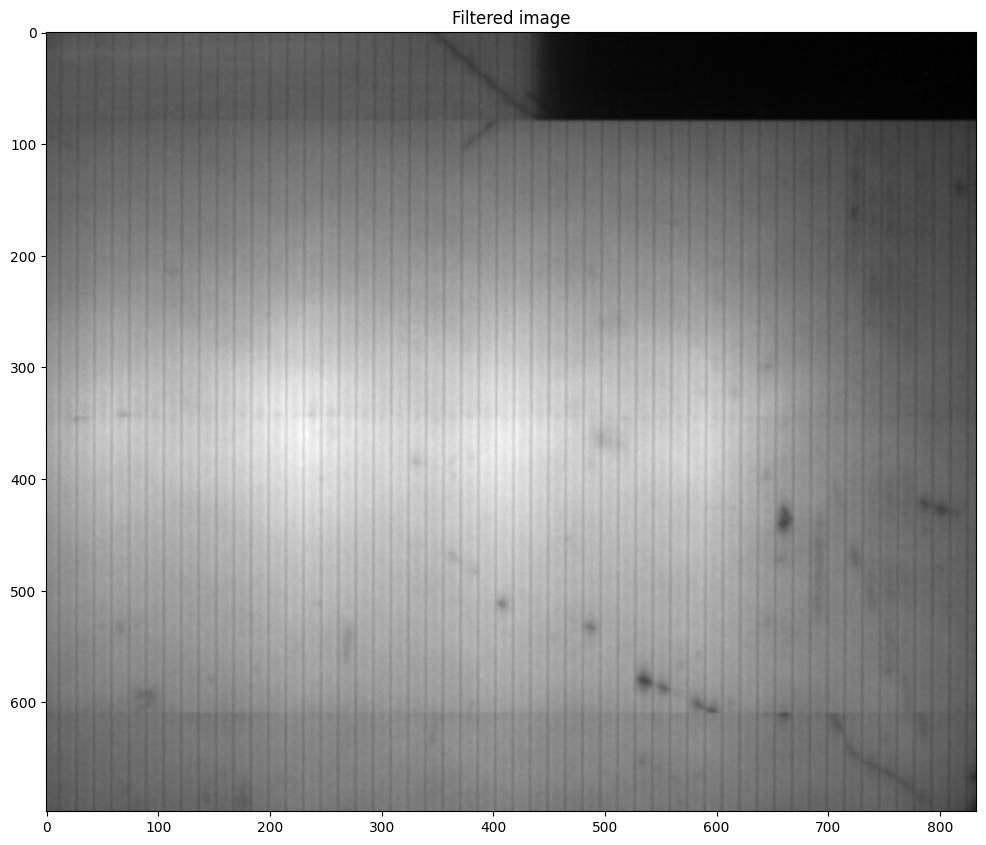

Implementierung mit OpenCV ist um den Faktor 1698.18 schneller als die eigene Implementierung
bright area: mean 142.3, std: 14.4, SNR: 19.9 dB
dark area: mean 7.7, std: 1.5, SNR: 14.1 dB
Contrast between mean of bright and dark area: 134.6


In [40]:
# filtering the image with a 2D gaussian kernel using opencv

def filter_2d_with_bib(img, kernel):
    """ apply a 2D filter to the image using opencv"""

    filtered = cv2.filter2D(img, -1, kernel)

    return filtered

# apply the filter to the image
kernel = get_gauss_kernel((5,5), 1)

start = time.time()
filtered_2d_bib = filter_2d_with_bib(roi_discarded_bars_stretched, kernel)
stop = time.time()
elapsed_with_bib = stop - start

print(f"Size of original image: {roi_discarded_bars_stretched.shape}")
print(f"Size of filtered image: {filtered_2d_bib.shape}")
print(f"Time taken: {elapsed_with_bib:.3f} seconds")

evaluate(filtered_2d_bib)

plt.figure(figsize=(12, 12))
plt.imshow(filtered_2d_bib, cmap='gray')
plt.title('Filtered image')
plt.show()

print(f"Implementierung mit OpenCV ist um den Faktor {elapsed_2d / elapsed_with_bib:.2f} schneller als die eigene Implementierung")
evaluate(filtered_2d_bib)


In [41]:
# zum Vergleich
evaluate(roi_discarded_bars_stretched)

bright area: mean 142.3, std: 15.1, SNR: 19.5 dB
dark area: mean 7.7, std: 1.8, SNR: 12.7 dB
Contrast between mean of bright and dark area: 134.6


### Bewertung
Das Filtern mittels eines 2D-Filter bedarf 2.48 mal mehr Multipikationen, als das Filtern mittels zweier 1D-Filter und benötigt um das 1.37fache weniger Zeit. Das liegt daran, dass bei zum Beispiel einem Filterkern der Größe 3x3 beim 2D-Filter 9 Multiplikationen pro Pixel stattfinden, während bei zwei 1D-Filtern jeweils nur 3, also in Summe 6 Multiplikationen nötig sind.

Die Filterung mittels OpenCV ist deutlich (ca. 1700 mal) schneller, weil das Iterieren über das Bild in Python sehr langsam ist, während OpenCV auf einer effizienteren, hardwarenäheren Implementierung beruht.

Das Signal-Rausch-Verhältnis ist minimal besser geworden, da kleine Schwankungen zwischen benachbarten Pixeln leicht geglättet wurden. Da allerdings auf der gesamten Fläche des ausgewählten Bereichs noch größere Helligkeitsschwankungen vorkommen - die Bild Mitte ist heller als der Rand - ist das Verhältnis nur geringfügig gestiegen.

Der Kontrast ist im Vergleich zum ungefilterten Bild gleich geblieben, da sich durch die Filterung die durchschnittliche Helligkeit nicht verändert hat.




